In [5]:
# Import modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
from scipy.interpolate import interp1d
from sklearn.metrics import r2_score

# Get the current working directory
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))

# APC Biallelic Cancer Progression Probabilities, 100kGP
This script calculates the frequencies of APC genotypes in the 100KGP cohort (Section 2) and the corresponding mutational probabilities in the healthy colon (Section 3) to estimate the relative cancer progression probablity of different APC genotypes (Section 4), as outlined in the main text.
In Section 5 we derive the rates of copy-loss and copy-neutral LOH.

## 1. Import data

### 1.1 Relative probabilitiy of truncating mutations by APC region
See scripts in /Signature Analysis.

Data from Lee-Six, Henry, et al. "The landscape of somatic mutation in normal colorectal epithelial cells." Nature 574.7779 (2019): 532-537.

In [6]:
# From healthy crypts signature analysis, import the weighted probabilities of indels and stop-gained mutations in each region of APC

IDS_corrected=pd.read_csv(parent_dir+'/Signature Analysis/Results/Indels_corrected.csv')
SBS_corrected=pd.read_csv(parent_dir+'/Signature Analysis/Results/Stops_corrected.csv')



### 1.2 100KGP APC count tables

Data from Cornish, Alex J., et al. "Whole genome sequencing of 2,023 colorectal cancers reveals mutational landscapes, new driver genes and immune interactions." bioRxiv (2022): 2022-11. Scripts for obtaining the count tables available in the Genomics England portal. 


In [7]:
# From 100KGP, import count table with APC copy number, mutation types and location, and copy-number status (combning analysis from Cornish 22)

data=pd.read_csv('Data/100KGP/MSS_WGD.csv')
print('Total number of samples:', sum(data['Counts']))



Total number of samples: 1181


## 2. Genotype samples
Given the location and type of truncating mutations in APC, the copy number status and the whole genome duplication status of each sequenced CRC sample, determine the APC genotype as outilned in Methods.

In [8]:
# Functions for data analysis

def parse_coordinates(input_string):
    # Extract numerical values using regular expression
    matches = re.findall(r'[-+]?\d*\.\d+|\d+', input_string)

    # Convert the extracted values to float and then to a NumPy array
    result_array = np.array([float(match) for match in matches])

    return result_array

def parse_variable_coordinates(input_string):

    matches = re.findall(r'[-+]?\d*\.\d+|\d+', input_string)
    result_array = np.array([float(match) for match in matches])
    return result_array

def reproduce_dataset(original_dataframe):
    reproduced_dataset = []

    for _, row in original_dataframe.iterrows():
        entry, count = row['Type'], row['Counts']
        reproduced_dataset.extend([entry] * count)

    return pd.DataFrame({'Type': reproduced_dataset})

def count_substring_occurrences(array, substring):
    total_count = 0
    for string in array:
        total_count += string.count(substring)
    return total_count

In [9]:
# Genotyping of 100KGP data


def data_analysis(data):

    data['Copy_number']=data['Copy_number_1'].apply(parse_coordinates)
    data['Regions']=data['Regions'].apply(parse_variable_coordinates)
    leng=[]
    for d in data['Regions']:
        leng.append(len(d))

    data['#_muts']=leng

    summary = data['Copy_number'].value_counts()
    summary =data['Copy_number'].apply(tuple)

    # Use value_counts to summarize unique entries and their counts
    data['Category'] = data['Copy_number'].apply(tuple)

    # Use value_counts to summarize unique entries and their counts
    summary = data.groupby('Category')['Counts'].sum().reset_index(name='TotalValue')


    # Genotype
    genotype=[]
    for i in np.arange(len(data)):

        # Simple double mutants
        if np.array_equal(data['Copy_number'][i],[1,1]) and data['#_muts'][i]==2:
            genotype.append(str(np.sort(data['Regions'][i])))
            
        elif np.array_equal(data['Copy_number'][i],[2,2]) and data['#_muts'][i]==2:
            genotype.append(str(np.sort(data['Regions'][i])))

        # Simple single mutants
        elif np.array_equal(data['Copy_number'][i],[1,1]) and data['#_muts'][i]==1:
            genotype.append('sm')

        # Other single mutants
        elif len(data['Copy_number'][i])>0 and data['Copy_number'][i][1]>0 and data['#_muts'][i]==1:
            genotype.append('sm')

        # Double mutants with more than 2 mutations
        elif len(data['Copy_number'][i])>0 and data['Copy_number'][i][1]>0 and data['#_muts'][i]>1:
            genotype.append(str(np.sort(data['Regions'][i])[0:2]))
            
            

        # Simple copy-neutral with no WGD
        elif len(data['Copy_number'][i])>0 and data['Copy_number'][i][0]>1 and data['WGD'][i]==False:
            genotype.append(str(np.sort(data['Regions'][i])[0])+', x2')

        # Simple copy-loss
        elif len(data['Copy_number'][i])>0 and data['Copy_number'][i][0]==1:
            genotype.append(str(np.sort(data['Regions'][i])[-1])+', -')

        # Copy-neutral and copy-loss with WGD   
        elif len(data['Copy_number'][i])>0 and data['Copy_number'][i][1]==0 and data['WGD'][i]==True:
            if data['Copy_number'][i][0]>2 :#and  (data['Copy_number'][i][1] % 2) == 0: 
                genotype.append(str(np.sort(data['Regions'][i])[0])+', x2')
            elif data['Copy_number'][i][0]>1: 
                genotype.append(str(np.sort(data['Regions'][i])[-1])+', -')
            else:
                genotype.append('nk')


        else:
            genotype.append('nk')
            print(data['Copy_number'][i],)


    data['Genotype']=genotype

    #### # Use value_counts to summarize unique entries and their counts
    summary_cn = data.groupby('Genotype')['Counts'].sum().reset_index(name='Counts')
    return summary_cn


summary_cn=data_analysis(data)
summary=summary_cn.iloc[0:18]


summary
cs=[]
for c in summary['Counts']:
    cs.append(int(c))
summary['Counts']=cs
summary.to_csv('MSS_all_summary.csv')

[]
[]
[]
[]
[]


In [10]:
cs=[]
counts=[]
sg=[]
for i in np.arange(len(data)):
    cs.append(data['Types'][i].count('frameshift'))
    counts.append(data['Counts'][i])
    sg.append(data['Types'][i].count('stop'))

print('Stop-gained',sum(np.asarray(counts)*np.asarray(sg)), 'frameshifts', sum(np.asarray(counts)*np.asarray(cs)))
print('Ratio stop-gained: frameshift',int(3*sum(np.asarray(counts)*np.asarray(sg))/sum(np.asarray(counts)*np.asarray(cs))),':',int(3*sum(np.asarray(counts)*np.asarray(cs))/sum(np.asarray(counts)*np.asarray(cs))))#, 'frameshifts', sum(np.asarray(counts)*np.asarray(cs)))
print('Total samples considered for analysis:', sum(summary['Counts']))

Stop-gained 1024 frameshifts 762
Ratio stop-gained: frameshift 4 : 3
Total samples considered for analysis: 1037


## 3. Calculate mutation probabilities using somatic data

In [30]:
# Function to determine the total number of 20AARs

def aars(pr):
    if len(pr)==2:    
        if pr[1]==0.5:
            aar=pr[0]*2
        else:
            aar=sum(pr)
        
    else:
        aar=sum(pr)
    return aar

# Function to calculate the mutation probabilities of all APC genotypes

def NULL(L,I,fs,dels,cnlohs):
    L0=L[0]
    L1=L[1]
    L2=L[2]
    L3=L[3]

    I0=I[0]
    I1=I[1]
    I2=I[2]
    I3=I[3]

    m0=1
    
    # relative to m0
    
    m1=(L1*fs+(1-fs)*I1) /(L0*fs+(1-fs)*I0)
    m2=(L2*fs+(1-fs)*I2 )/(L0*fs+(1-fs)*I0)
    m3=(L3*fs+(1-fs)*I3 )/(L0*fs+(1-fs)*I0)

    md=(dels/dms)*0.5
    mn=(cnlohs/dms)

    total=(mn+md+1+m1+m2+m3)
    t=total

    m1=m1/t
    m2=m2/t
    m0=1/t
    m3=m3/t
    mn=mn/t
    md=md/t


    
    m00=m0**2
    m11=m1**2
    m22=m2**2
    m33=m3**2
    
    m01=2*m1*m0
    m02=2*m2*m0
    m03=2*m0*m3
    
    m12=2*m1*m2
    m23=2*m2*m3
    m13=2*m1*m3
    
    md0=2*m0*md
    md1=2*m1*md
    md2=2*m2*md
    md3=2*m3*md
    
    mn0=m0*mn
    mn1=m1*mn
    mn2=m2*mn
    mn3=m3*mn
    
    
    Types_double=[[0,0],[1,1],[2,2],[3,3],[0,1],[1,2],[1,3],[0,2],[2,3],[0,3],[0],[1],[2],[3],[0,0.5],[1,0.5],[2,0.5],[3,0.5]]
    aar=[]
    for t in Types_double:
        aar.append(aars(t))
        
    Types_double=['[0, 0]','[1, 1]','[2, 2]','[3, 3]','[0, 1]','[1, 2]','[1, 3]','[0, 2]','[2, 3]','[0, 3]','[0]','[1]','[2]','[3]','[0, x2]','[1, x2]','[2, x2]','[3, x2]']
    probs_double=np.asarray([m00, m11, m22, m33, m01, m12, m13, m02, m23, m03,md0,md1,md2,md3, mn0, mn1, mn2,mn3])

        

    return pd.DataFrame(data={'Genotype':Types_double,'20AARs':aar ,'Probabilities':probs_double/sum(probs_double)})#,pd.DataFrame(data={'Genotype':types,'Probabilities':probs_s/sum(probs_s)})



In [31]:
# Find weight per region for stop_gained mutations

p0=sum(SBS_corrected['Norm probability'][SBS_corrected['Region']=='R0'])
p1=sum(SBS_corrected['Norm probability'][SBS_corrected['Region']=='R1'])
p2=sum(SBS_corrected['Norm probability'][SBS_corrected['Region']=='R2'])
p3=sum(SBS_corrected['Norm probability'][SBS_corrected['Region']=='R3'])
L=np.asarray([p0,p1,p2,p3])
L=L/sum(L)


# Find weight per region for indels 

p0=sum(IDS_corrected['Norm probability'][IDS_corrected['Region']=='R0'])
p1=sum(IDS_corrected['Norm probability'][IDS_corrected['Region']=='R1'])
p2=sum(IDS_corrected['Norm probability'][IDS_corrected['Region']=='R2'])
p3=sum(IDS_corrected['Norm probability'][IDS_corrected['Region']=='R3'])
I=np.asarray([p0,p1,p2,p3])
I=I/sum(I)

fs=1 - (3/7) # Probabilty of stop-gained, MSS

total_weights=(L[0]*fs + I[0]* fs)/sum(L*fs + I* fs)

# Find number of samples with (0,0), (0,-) and (0,x2) genotypes to calculate probabilities of CL-LOH and CN-LOH
dms=summary['Counts'].iloc[8]
dels=summary['Counts'].iloc[0]
cnlohs=summary['Counts'].iloc[1]


null=NULL(L,I,fs,dels,cnlohs)

Types_double=[[0,0],[1,1],[2,2],[3,3],[0,1],[1,2],[1,3],[0,2],[2,3],[0,3],[0],[1],[2],[3],[0,0.5],[1,0.5],[2,0.5],[3,0.5]]
null['Type'] =Types_double
null['Type'] =null['Type'].apply(tuple)
null.to_csv('Results/Mutation_probabilities_MSS.csv')



## 4. Calculate cancer progression probabilities

In [32]:
# Function to calculate the progression probabilities from mutation probabilities and frequencies of APC genotypes

def progression_probability(df,null_=null):
    entry_count=[]
    for t in list(null_['Type']):
        entry_count.append(len(df[df['Type'] == t]))


    null_['Counts']=entry_count
    null_['Frequency']=np.asarray(entry_count)/sum(np.asarray(entry_count))
    
    
    probs=np.asarray(null_['Frequency'])/np.asarray(null_['Probabilities'])
    probs=probs/sum(probs)
    null_['Progression']=probs
    
    return np.asarray(null_['Progression'])

# Function to calculate the number of 20AARs with maximal progression probabiliy

def max_20AARs(df,null_=null):
    entry_count=[]
    for t in list(null_['Type']):
        entry_count.append(len(df[df['Type'] == t]))


    null_['Counts']=entry_count
    
    
    
    nullc=null_.groupby('20AARs',as_index=False).sum()

    nullc['Frequency']=nullc['Counts']/sum(nullc['Counts'])    
    
    probs=np.asarray(nullc['Frequency'])/np.asarray(nullc['Probabilities'])
    probs=probs/sum(probs)
    
    
    nullc['Progression']=probs
    
    max_row_index = nullc['Progression'].idxmax()
    value_in_column1 = nullc.loc[max_row_index, '20AARs']
    
    
    
    return int(value_in_column1)

# Function to calculate the progression-weighted mean number of 20AARs 

def mean_20AARs(df,null_=null):
    entry_count=[]
    for t in list(null_['Type']):
        entry_count.append(len(df[df['Type'] == t]))


    null_['Counts']=entry_count

        
    nullc=null_.groupby('20AARs',as_index=False).sum()
    
    nullc = nullc.sort_values(by='20AARs')


    nullc['Frequency']=nullc['Counts']/sum(nullc['Counts'])
    
    
    probs=np.asarray(nullc['Frequency'])/np.asarray(nullc['Probabilities'])
    probs=probs/sum(probs)
    
    
    nullc['Progression']=probs
    mean_20AAR=0
    for a in np.arange(7):
        mean_20AAR+=a*probs[a]
        

    return mean_20AAR
        
# Function to calculate the progression probabilities from mutation probabilities and frequencies of numbers of 20AARs

def progression_probability_20AARs(df,null_=null):
    
    entry_count=[]
    for t in list(null_['Type']):
        entry_count.append(len(df[df['Type'] == t]))


    null_['Counts']=entry_count

        
    nullc=null_.groupby('20AARs',as_index=False).sum()
    
    nullc = nullc.sort_values(by='20AARs')


    nullc['Frequency']=nullc['Counts']/sum(nullc['Counts'])
    
    
    probs=np.asarray(nullc['Frequency'])/np.asarray(nullc['Probabilities'])
    probs=probs/sum(probs)
    
    
    nullc['Progression']=probs

    return np.asarray(   nullc['Progression'])

    
# Functions to find CI by bootstrapping

def bootstrap_func_values_ci(dataframe, func, n_iterations, confidence_level,*args):

    # Extract the specified column from the DataFrame
    values = dataframe['Type'].values
    try:
        N=len(func(dataframe,*args))
    except TypeError:
    # Handle the TypeError by returning '1'
        N= 1

    # Initialize arrays to store the bootstrapped values for each iteration
    bootstrapped_values = np.zeros((n_iterations, N))

    # Perform bootstrapping
    for i in range(n_iterations):
        # Generate a bootstrap sample with replacement
        bootstrap_sample = pd.DataFrame({'Type': np.random.choice(values, size=len(values), replace=True)})

        a=func(bootstrap_sample)
        
        # Compute the desired values using the user-defined function with parameters
        bootstrapped_values[i, :] = func(bootstrap_sample,*args)

    # Compute mean values for each iteration
    mean_values = np.mean(bootstrapped_values, axis=0)

    # Compute confidence intervals for each iteration
    alpha = (1 - confidence_level) / 2
    ci_lower_values = np.percentile(bootstrapped_values, alpha * 100, axis=0)
    ci_upper_values = np.percentile(bootstrapped_values, (1 - alpha) * 100, axis=0)

    return mean_values, ci_lower_values, ci_upper_values

Use 100kGP summary table of APC genotypes combined with the null model to calculate cancer progression probabilities of all APC genotypes and perform statistics.

In [33]:
KGP = summary
Types_double=[[0],[0,0.5],[1],[1,0.5],[2],[2,0.5],[3],[3,0.5],[0,0],[0,1],[0,2], [0,3],[1,1],[1,2],[1,3],[2,2],[2,3],[3,3]]#,[0,1],[1,2],[1,3],[0,2],[2,3],[0,3]]

KGP['Type'] =Types_double
KGP['Type'] =KGP['Type'].apply(tuple)

# Turn frequency table into dataset to use bootstrapping
df_KGP = reproduce_dataset(KGP)

# Bootstrapping of progression probability by genotype
pmn,lmn,hmn = bootstrap_func_values_ci(df_KGP, progression_probability, 1000, 0.95,null)

null['Progression']=pmn
null['CIH']=lmn
null['CIL']=hmn
#null_results.to_csv('Results/summary_100kgp.csv')

# Bootstrapping of progression probability by 20AAR
px_m,lx_m,hx_m = bootstrap_func_values_ci(df_KGP, progression_probability_20AARs, 1000, 0.95,null)


# Bootstrapping of max 20AAR
Max,lmx,hmx = bootstrap_func_values_ci(df_KGP, max_20AARs, 1000, 0.99,null)
print('Number of samples considered:', sum(null['Counts']))
print('Max 20AARs:',int(Max),', 95% CI', lmx,hmx)
print('We reject the Maximal loss implies maximal risk as 0 20AARs is not in the 99% CI for the maximal progression probability')
print('We conclude that data is consistent with Just right as 2 20AAR is in the 99% CI for the maximal progression probability')

# Bootstrapping of  progression-weighted mean number of 20AARs 
Meanx,Mlmx,Mhmx = bootstrap_func_values_ci(df_KGP, mean_20AARs, 1000, 0.95,null)
print('Progression-weighted mean number of total retained 20AARs in MSS, 100KGP cohort:',Meanx, ', 95% CI', Mlmx,Mhmx)


Number of samples considered: 1037
Max 20AARs: 2 , 95% CI [2.] [2.]
We reject the Maximal loss implies maximal risk as 0 20AARs is not in the 99% CI for the maximal progression probability
We conclude that data is consistent with Just right as 2 20AAR is in the 99% CI for the maximal progression probability
Progression-weighted mean number of total retained 20AARs in MSS, 100KGP cohort: [2.56933653] , 95% CI [2.29486575] [2.82993221]


In [34]:
# Weighted mean progression prbbalitye by samples counts

df= reproduce_dataset(KGP)
entry_count=[]
for t in list(null['Type']):
    entry_count.append(len(df[df['Type'] == t]))
null['Counts']=entry_count

    
mean0=null['Progression'][0]*null['Counts'][0] + null['Progression'][10]*null['Counts'][10] + null['Progression'][14]*null['Counts'][14] 
mean0=mean0/(null['Counts'][0] + null['Counts'][10] + null['Counts'][14] )

mean1=null['Progression'][4]*null['Counts'][4] + null['Progression'][11]*null['Counts'][11] 
mean1=mean1/(null['Counts'][4] + null['Counts'][11])

mean2=null['Progression'][1]*null['Counts'][1] + null['Progression'][7]*null['Counts'][7] + null['Progression'][12]*null['Counts'][12] + null['Progression'][15]*null['Counts'][15] 
mean2=mean2/(null['Counts'][1] + null['Counts'][7] + null['Counts'][12] +null['Counts'][15]  )

mean3=null['Progression'][5]*null['Counts'][5] + null['Progression'][9]*null['Counts'][9] + null['Progression'][13]*null['Counts'][13] 
mean3=mean3/(null['Counts'][5] + null['Counts'][9] + null['Counts'][13] )

mean4=null['Progression'][2]*null['Counts'][2] + null['Progression'][6]*null['Counts'][6] + null['Progression'][16]*null['Counts'][16] 
mean4=mean4/(null['Counts'][2] + null['Counts'][6] + null['Counts'][16] )

mean5=null['Progression'][8]*null['Counts'][8] 
mean5=mean5/(null['Counts'][8] )

mean6=null['Progression'][3]*null['Counts'][3] + null['Progression'][17]*null['Counts'][17] 
mean6=mean6/(null['Counts'][3] + null['Counts'][17] )

weighted_mean = np.asarray([mean0,mean1,mean2,mean3,mean4,mean5,mean6])

# Find R2 fit 
interpolated_function = interp1d(np.arange(7), weighted_mean, kind='linear', fill_value="extrapolate")
predicted_y = interpolated_function(np.asarray(null['20AARs']))
r2 = r2_score(np.asarray(null['Progression']), predicted_y)

print("R-squared fit between progerssion probailities by genotype and total 20AARs:", r2)

R-squared fit between progerssion probailities by genotype and total 20AARs: 0.8210229972640881


In [35]:
print('Genoytpe (1,1) is at '+str(int(max(null['Progression'])/min(null['Progression'])))+'X higher relative progression probability than (0,0)')

Genoytpe (1,1) is at 51X higher relative progression probability than (0,0)


In [36]:
# Save mutation probabilities, frequencies and progression probabilities for 100KGP MSS
null.to_csv('Results/MSS_100KGP_by_genotype.csv')

# Save progression probabilities by 20AAR
progression_20AARs=pd.DataFrame(data={'20AARs':np.arange(7) ,'100KGP Progression Probability':px_m, 'CLow':lx_m,'CHigh': hx_m})#,pd.DataFrame(data={'Genotype':types,'Probabilities':probs_s/sum(probs_s)})
progression_20AARs.to_csv('Results/MSS_100KGP_by_20AARs.csv')



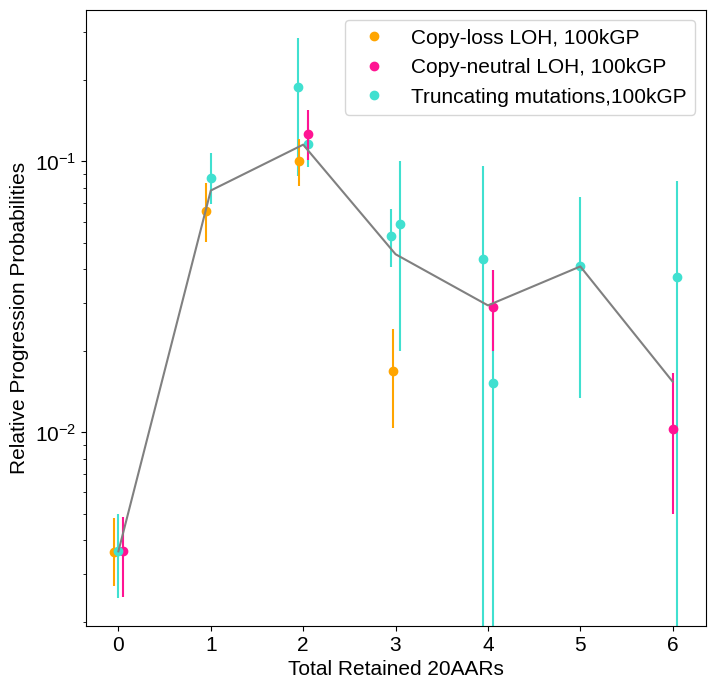

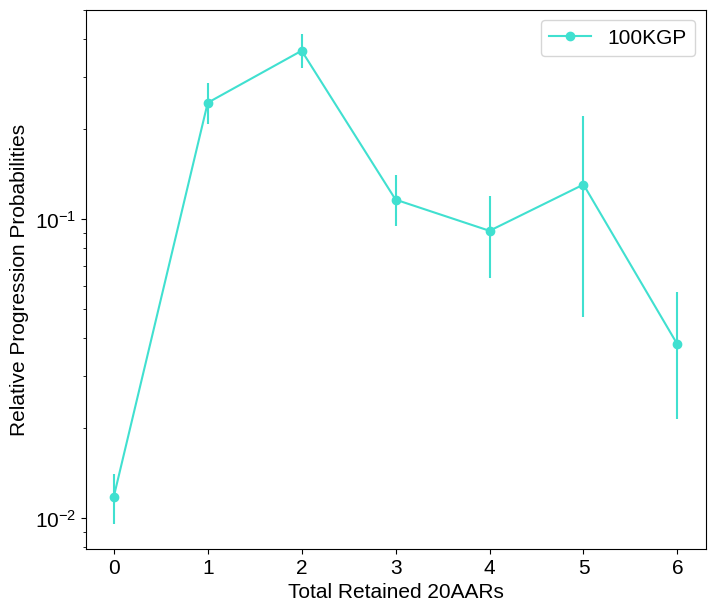

In [37]:
# Plot results

plt.figure(figsize=(8,8))
plt.rcParams.update({'font.size': 15})
plt.rcParams['font.family'] = 'Liberation Sans'


for i in [8,4]:
    plt.plot(np.asarray(null['20AARs'][i]),np.asarray(null['Progression'][i]),'o',color='turquoise')
    plt.vlines(np.asarray(null['20AARs'][i]),np.asarray(null['CIL'][i]),np.asarray(null['CIH'][i]),color='turquoise')#

for i in [2,1,9]:
    plt.plot(np.asarray(null['20AARs'][i])-0.051,np.asarray(null['Progression'][i]),'o',color='turquoise')
    plt.vlines(np.asarray(null['20AARs'][i])-0.051,np.asarray(null['CIL'][i]),np.asarray(null['CIH'][i]),color='turquoise')#
    
for i in [3,5,6,7]:
    plt.plot(np.asarray(null['20AARs'][i])+0.051,np.asarray(null['Progression'][i]),'o',color='turquoise')
    plt.vlines(np.asarray(null['20AARs'][i])+0.051,np.asarray(null['CIL'][i]),np.asarray(null['CIH'][i]),color='turquoise')#


for i in [10,11,12]:
    plt.plot(np.asarray(null['20AARs'][i])-0.05,np.asarray(null['Progression'][i]),'o',color='orange')#, label='100KGP, truncating mutations')#  
    plt.vlines(np.asarray(null['20AARs'][i])-0.05,np.asarray(null['CIL'][i]),np.asarray(null['CIH'][i]),color='orange')#


for i in [13]:
    plt.plot(np.asarray(null['20AARs'][i])-0.03,np.asarray(null['Progression'][i]),'o',color='orange', label='Copy-loss LOH, 100kGP')#  
    plt.vlines(np.asarray(null['20AARs'][i])-0.03,np.asarray(null['CIL'][i]),np.asarray(null['CIH'][i]),color='orange')#

for i in [14,15,16]:
    plt.plot(np.asarray(null['20AARs'][i])+0.051,np.asarray(null['Progression'][i]),'o',color='deeppink')
    plt.vlines(np.asarray(null['20AARs'][i])+0.051,np.asarray(null['CIL'][i]),np.asarray(null['CIH'][i]),color='deeppink')#

for i in [17]:
    plt.plot(np.asarray(null['20AARs'][i]),np.asarray(null['Progression'][i]),'o',color='deeppink', label='Copy-neutral LOH, 100kGP')#  
    plt.vlines(np.asarray(null['20AARs'][i]),np.asarray(null['CIL'][i]),np.asarray(null['CIH'][i]),color='deeppink')#


for i in [0]:
    plt.plot(np.asarray(null['20AARs'][i]),np.asarray(null['Progression'][i]),'o',color='turquoise', label='Truncating mutations,100kGP')#  
    plt.vlines(np.asarray(null['20AARs'][i]),np.asarray(null['CIL'][i]),np.asarray(null['CIH'][i]),color='turquoise')#


plt.plot(np.arange(7),np.asarray(weighted_mean),'-',color='grey')    
plt.legend()
plt.yscale('log')
plt.yscale('log')
plt.xlabel('Total Retained 20AARs')
plt.ylabel('Relative Progression Probabilities')
plt.legend()
plt.savefig('Results/3ED.svg',dpi=300)


plt.figure(figsize=(8,7))
plt.rcParams.update({'font.size': 15})
plt.rcParams['font.family'] = 'Liberation Sans'

plt.plot(np.arange(7),px_m,'o-',color='turquoise',label='100KGP')
plt.vlines(np.arange(7),lx_m,hx_m,color='turquoise')

plt.legend()
plt.yscale('log')
plt.xlabel('Total Retained 20AARs')
plt.ylabel('Relative Progression Probabilities')
plt.legend()

plt.savefig('Results/Sup100KGPcn.svg',dpi=300)


## 5. Estimate rates of CL-LOH and CN-LOH

We use the analysis above to estimate per year mutation rates, assuming that mutations occur at a constant rate in cells. Lee-Six et al (2019) estimate an average of 43.6 SBSs per year in healthy crypts, which corresponds to a rate of  $\mu_{sbs}\approx 1.45\cdot10^{-8}$  substitutions per base-pair per year. The four considered APC regions comprise 4717  bases, and, as outlined above, only $\approx 5.2\%$ of possible SBSs within these regions are expected to be stop-gained mutations. Further, we expect a ratio of stop-gained to frameshifts of approximately $4:3$. Hence, truncating mutations occur within the APC regions at a per-year rate of $\mu_{APC}\approx 4717  \mu_{sbs} 0.052   (1+ \tfrac{3}{4} ) = 6.22 \cdot 10^{-6}$.

In [32]:
# Find rate of truncating mutations in region R0

mu_APC= 6.22*(10**(-6))
print('Weighted proportion of frameshifts and stop-gained mutations that fall in Region 0:' ,total_weights)
mu_0= total_weights * mu_APC
print('Rate of truncating mutations in R0:', mu_0)

# Find frquencies of genotypes (0,0), (0,-) and (0,x2)
f00= dms/(dels+dms+cnlohs)
f0d= dels/(dels+dms+cnlohs)
f0x= cnlohs/(dels+dms+cnlohs)
print('% of tumors with complete APC loss driven by two truncating mutations:' , f00)
print('% of tumors with complete APC loss driven by a truncating mutations and CL-LOH:' , f0d)
print('% of tumors with complete APC loss driven by a truncating mutations and CN-LOH:' , f0x)

# Calculate rates of CN-LOH and CL-LOH (see Methods)
mu_0d= (f0d/f00)*(mu_0/2)
mu_0x= (f0x/f00)*(mu_0)
print('Rate of CL-LOH:', mu_0d)
print('Rate of CN-LOH:', mu_0x)


Weighted proportion of frameshifts and stop-gained mutations that fall in Region 0: 0.7928062693685748
Rate of truncating mutations in R0: 4.931254995472535e-06
% of tumors with complete APC loss driven by two truncating mutations: 0.22875816993464052
% of tumors with complete APC loss driven by a truncating mutations and CL-LOH: 0.43790849673202614
% of tumors with complete APC loss driven by a truncating mutations and CN-LOH: 0.3333333333333333
Rate of CL-LOH: 4.7199154956665695e-06
Rate of CN-LOH: 7.185542993402837e-06
